# В данном Jupyter Notebook проводится подготовка данных ChEMBL (29v) для обучающей выборки

Пайплайн:

1. Скачивание данных ChEMBL;
2. Удаление активностей по отношению к мутантным каналам hERG
3. Стандартизация единиц измерения активности к herg каналам
  - приведение к одним единицам измерения (nM)
  - пересчет в pIC50
4. Удаление дубликатов
5. Проверка на точность соотношений (=, >, <)
6. Чистка с помощью RDKit
7. Удаление солевых форм
8. Сохранение подготовленных данных в .sdf и .csv файлы

# Обработка данных с ChEMBL, traget = "CHEMBL240"

In [39]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, MolStandardize
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import pandas as pd
import numpy as np
import logging

In [40]:
#! pip install chembl_webresource_client
from chembl_webresource_client.new_client import new_client

Подготовка данных для обучающей выборки

Посмотрим на все target, которые соответствуют поисковому запросу "herg"

In [41]:
target = new_client.target
target_query = target.search('herg')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Q12809', 'xref_name': None, 'xre...",Homo sapiens,HERG,19.0,False,CHEMBL240,"[{'accession': 'Q12809', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Melanin-concentrating hormone receptor 2/HERG,11.0,False,CHEMBL4106188,"[{'accession': 'Q12809', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Homo sapiens,Voltage-gated potassium channel,2.0,False,CHEMBL2362996,"[{'accession': 'P51787', 'component_descriptio...",PROTEIN FAMILY,9606


C помощью комманд в комментах ниже можно подгрузить данные, соответствубщие конкретной мишени. Однако загрузка может идти долго, поэтому воспользуемся уже скачанным таким образом файлом herg_in_web.csv 

In [42]:
#selected_target = 'CHEMBL240'

In [43]:
#selected_target = targets.target_chembl_id[0]
#activity = new_client.activity
#res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
#df = pd.DataFrame.from_dict(res)
#df

In [44]:
# df.to_csv("herg_in_web.csv", encoding='utf-8', index=False)

Т.е. опционально: можно загрузить все данные онлайн (выше),но иногда может тормозить. А можно загрузить сырой csv, который был скачан в последний раз:

In [45]:
#другой способ
df = pd.read_table('herg_in_web.csv', sep = ",", engine='python')
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,305156,[],CHEMBL841079,Inhibition of hERG currents Kv11.1,T,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,14.0
1,NaN,305157,[],CHEMBL841078,Inhibitory concentration against hERG currents...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3.0
2,NaN,305244,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,32.2
3,NaN,305245,[],CHEMBL691013,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,5950.0
4,NaN,306561,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,NaN,20714494,[],CHEMBL4629912,Inhibition of human ERG by Ionworks electrophy...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.7
13196,NaN,20717354,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2007.0
13197,NaN,20717355,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1607.0
13198,NaN,20717356,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3352.0


In [46]:
print(df["assay_description"].unique())

['Inhibition of hERG currents Kv11.1'
 'Inhibitory concentration against hERG currents after prolonged depolarizing pulses'
 'K+ channel blocking activity in human embryonic kidney cells expressing HERG Kv11.1'
 'K+ channel blocking activity in Chinese hamster ovary cells expressing HERG Kv11.1'
 'K+ channel blocking activity in neuroblastoma cells expressing HERG Kv11.1'
 'K+ channel blocking activity in COS-7 African green monkey kidney derived cells expressing HERG Kv11.1'
 'Inhibition of Ikr current in isolated guinea pig myocytes during a 0.5 s voltage clamp step from -50 to -10 mV.'
 'Inhibition of K+ channel activity in CHO cells expressing HERG Kv11.1'
 'Inhibitory activity against Potassium channel HERG'
 'Inhibition of human Potassium channel HERG expressed in mammalian cells'
 'Blockade of the delayed rectifier K+ current (IKr) of guinea pig myocytes'
 'Inhibition of K+ channel activity in mammalian cells expressing HERG Kv11.1'
 'Inhibition of Potassium channel HERG'
 'Inhi

In [47]:
df = df[(df.assay_description != 'Inhibition of human ERG Y652A mutant expressed in HEK293 cells by whole cell patch clamp method') & (df.assay_description != 'Inhibition of human ERG F656A mutant expressed in HEK293 cells by whole cell patch clamp method')& (df.assay_description != 'Inhibition of human ERG S624A mutant expressed in HEK293 cells by whole cell patch clamp method') & (df.assay_description != "Binding affinity to human ERG F656A tetrameric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -120 mV by patch clamp method") & (df.assay_description != 'Binding affinity to human ERG F656A tandem dimeric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -120 mV by patch clamp method') & (df.assay_description != 'Binding affinity to human ERG S624A tetrameric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -40 mV by patch clamp method')  & (df.assay_description != 'Binding affinity to human ERG Y652A tetrameric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -40 mV by patch clamp method') & (df.assay_description != 'Binding affinity to human ERG Y652A tandem dimeric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -40 mV by patch clamp method')]

In [49]:
list(df.columns)

['activity_comment',
 'activity_id',
 'activity_properties',
 'assay_chembl_id',
 'assay_description',
 'assay_type',
 'assay_variant_accession',
 'assay_variant_mutation',
 'bao_endpoint',
 'bao_format',
 'bao_label',
 'canonical_smiles',
 'data_validity_comment',
 'data_validity_description',
 'document_chembl_id',
 'document_journal',
 'document_year',
 'ligand_efficiency',
 'molecule_chembl_id',
 'molecule_pref_name',
 'parent_molecule_chembl_id',
 'pchembl_value',
 'potential_duplicate',
 'qudt_units',
 'record_id',
 'relation',
 'src_id',
 'standard_flag',
 'standard_relation',
 'standard_text_value',
 'standard_type',
 'standard_units',
 'standard_upper_value',
 'standard_value',
 'target_chembl_id',
 'target_organism',
 'target_pref_name',
 'target_tax_id',
 'text_value',
 'toid',
 'type',
 'units',
 'uo_units',
 'upper_value',
 'value']

In [50]:
df["target_pref_name"].unique()

array(['HERG'], dtype=object)

In [51]:
df = df[['canonical_smiles', "molecule_chembl_id", 'standard_relation', 'standard_type', 'standard_units', 'units','value']]

In [52]:
def delete_duplicates_and_nan(df):
    df = df.dropna(subset = ["units", "standard_type", "value"])
    df = df.drop_duplicates(subset ="molecule_chembl_id")
    return df

In [53]:
df = delete_duplicates_and_nan(df)
df

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0
...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0


In [54]:
df.standard_units.unique()

array(['nM', 'ucm', 'ug.mL-1'], dtype=object)

In [55]:
df.units.unique()

array(['nM', 'uM', 'ucm', 'mM', 'umol', 'ug ml-1', "10'2 uM"],
      dtype=object)

In [56]:
df["MW"] = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(m)) for m in df["canonical_smiles"]] 

In [57]:
def to_one_unit(df):
    index_to_del = []
    value_nM = []
    for index, row in df.iterrows():
        value = float(row["value"])
        unit = row["units"]
        mw = float(row["MW"])
        if unit == 'uM':
            unit1 = value*1000
            value_nM.append(unit1)
        elif unit == 'ucm':
            unit1 = value*1000
            value_nM.append(unit1)
        elif unit == 'mM':
            unit1 = value*1000000
            value_nM.append(unit1)
        elif unit == 'umol':
            unit1 = value*1000
            value_nM.append(unit1)
        elif unit == "10'2 uM":
            unit1 = value*100000
            value_nM.append(unit1)
        elif unit == 'M':
            unit1 = value*1000000000
            value_nM.append(unit1)
        elif unit == 'ug ml-1':
            unit1 = value/mw
            value_nM.append(unit1)
        elif unit == 'nM':
            unit1 = value
            value_nM.append(unit1)
        else:
            index_to_del.append(index)
    df1 = df.drop(index_to_del)
    df1["value_nM"] = value_nM
    return df1

In [58]:
df = to_one_unit(df)
df

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0
...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0


In [59]:
def activity_class(df):
    activity_class =[]
    for index, row in df.iterrows():
        value = float(row["value_nM"])
        relation = str(row["standard_relation"])
        if value > 10000:
             activity_class.append(0)
        elif value == 10000 and relation == ">":
            activity_class.append(0)
        elif value == 10000 and relation == ">=":
            activity_class.append(0)
        elif value == 10000 and relation == "<":
            activity_class.append(1)
        else:
            activity_class.append(1)
    df['class'] = activity_class
    return df

In [60]:
df = activity_class(df)
df

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0,1
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0,1
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1
...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1


In [61]:
def relation_review(df):
    index_to_del = []
    Number_of_exactly = 0
    nubmer_of_false = 0
    i = 0
    for index, row in df.iterrows():
        relation = str(row['standard_relation'])
        activity_value = row['value_nM']
        if relation == "=":
            Number_of_exactly += 1
        elif relation == '>'and activity_value < 10000:
            nubmer_of_false += 1
            index_to_del.append(index)
        elif relation == '<'and activity_value > 10000:
            nubmer_of_false += 1 
            index_to_del.append(index)
    df1 = df.drop(index_to_del)
    return df1

In [62]:
df = relation_review(df)
df

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0,1
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0,1
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1
...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1


In [63]:
def calculate_pIC50(i):
    p = -np.log10(i/1000000000)
    return p

In [64]:
df["pIC50"] = df['value_nM'].apply(calculate_pIC50)
df

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0,1,7.853872
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0,1,5.225483
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1,6.844664
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1,6.707744
...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696


In [65]:
def standardize_smiles(df):
    logs = 0
    mols = []
    for i in df["canonical_smiles"]:    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(logs)
    df["ROMol"] = mols
    return df

In [66]:
df = standardize_smiles(df)
df

0


,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0,1,7.853872,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0,1,5.225483,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1,6.844664,"<img data-content=""rdkit/molecule"" src=""data:i..."
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1,6.707744,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,"<img data-content=""rdkit/molecule"" src=""data:i..."
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,"<img data-content=""rdkit/molecule"" src=""data:i..."
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,"<img data-content=""rdkit/molecule"" src=""data:i..."
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,"<img data-content=""rdkit/molecule"" src=""data:i..."


запретим RDkit выдавать логи помимо логов-ошибок

In [70]:
logging.getLogger('rdkit.Chem.MolStandardize.rdMolStandardize').setLevel(logging.ERROR)
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0,1,7.853872,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F)cc1,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c1c[nH]c2ccccc12,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0,1,5.225483,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1,6.844664,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
5,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(F)F)ccc12,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1,6.707744,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(C(C)C)n1,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C@@H]3C)ccc1-n1cnc(C)c1,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2)[C@@H]3C)ccc1-n1cnc(C)c1,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC2)ccc1-n1cnc(C)c1,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

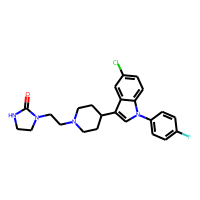
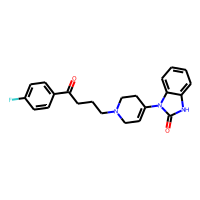
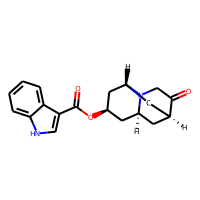
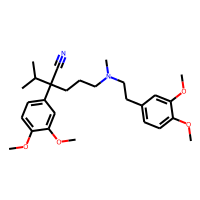
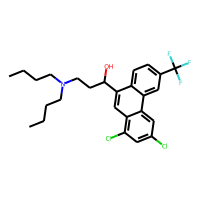
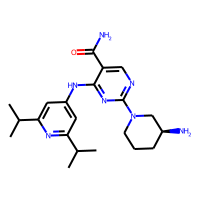
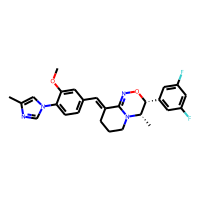
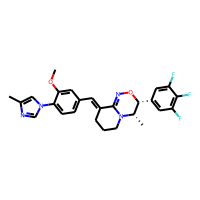
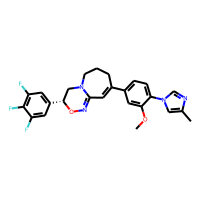
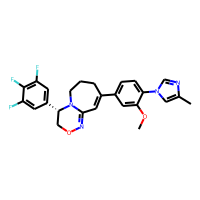

In [71]:
df["ROMol"].map(rdMolStandardize.Cleanup)
df

In [72]:
df = df.drop(df[df.canonical_smiles.str.contains(r'[.]')].index)

In [35]:
PandasTools.WriteSDF(df, 'herg_smaller_right.sdf', molColName='ROMol', properties=list(df.columns))

In [36]:
df.drop(["ROMol"], axis=1, inplace=True)

In [37]:
df.to_csv("herg_out_smaller_right.csv", encoding='utf-8', index=False)

еще сохраним данные для MolProp в smi

In [38]:
df1 = df["canonical_smiles"]
df1.to_csv("herg_for_molprop_3.smi", sep = ",", encoding='utf-8', index=False)

# Вывод:
Была проведена предобработка и фильтрация соединений по этапам: 


In [74]:
tabledata = [[1, "Скачивание всех активностей в IC50", 13200],
         [2, "Исключение активностей по отношению к мутантным формам hERG", 13181],
         [3, "Исключение дубликатов (по ChEMBL_ID) и удаление строк с путыми значениями в колонках units, standard_type, value", 8253],
         [4, "Приведение всех значений IC50 к одним единицам измерения (nM)", 8253],
         [5, "Проставление меток класса (граница IC50 = 10 мкМ)", 8253],
         [6, "Исключение соединений с пропущенными или неопределенными значениями в realtion", 8158],
         [7, "Расчет pIC50", 8158],
         [8, "Стандартизация RDkit", 8158],
         [9, "Исключение солевых форм", 7879]    
            ]

In [76]:
pd.set_option('max_colwidth', None)
pd.DataFrame(tabledata, columns=["№","Действие", "Число соединений"])

,№,Действие,Число соединений
0,1,Скачивание всех активностей в IC50,13200
1,2,Исключение активностей по отношению к мутантным формам hERG,13181
2,3,"Исключение дубликатов (по ChEMBL_ID) и удаление строк с путыми значениями в колонках units, standard_type, value",8253
3,4,Приведение всех значений IC50 к одним единицам измерения (nM),8253
4,5,Проставление меток класса (граница IC50 = 10 мкМ),8253
5,6,Исключение соединений с пропущенными или неопределенными значениями в realtion,8158
6,7,Расчет pIC50,8158
7,8,Стандартизация RDkit,8158
8,9,Исключение солевых форм,7879
